In [1]:
# General tools
import pandas as pd
import numpy as np
from numpy import where
import matplotlib.pyplot as plt
import seaborn as sns

#import requests
import requests
import json

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances

# For the tree visualization
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics
from sklearn.metrics import log_loss


# For validation
from sklearn.model_selection import train_test_split, cross_val_score,\
    GridSearchCV
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


**Motivation:** [picture](https://drive.google.com/file/d/1SLw5hZHcn3JrhKEZOfV99T_P_2nz4SY6/view?usp=sharing)
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a long term deposit (variable y).

In [2]:
# define api to get bank data
domain = 'https://www.mldata.io'
root = 'get-data/dataset/label-encoded/bank_marketing/?format = json'
url_bank_data = f'{domain}/{root}'
# get data from api
bank_data_json = json.loads(requests.get(url_bank_data).text)
bank_data_json.keys()

dict_keys(['name', 'missing_values', 'instances_count', 'attribute_count', 'attribute_names', 'attribute_types', 'attribute_descriptions', 'values'])

In [3]:
bank_data_json['attribute_descriptions']

['Age of client: numerical value',
 'Type of job: admin., blue-collar, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown',
 'Marital status: divorced, married, single, unknown',
 'Level of education: primary, secondary, tertiary, unknown',
 'Has credit in default: no, yes, unknown',
 'Average yearly balance in Euro: numerical value',
 'Has housing loan: no, yes, unknown',
 'Has personal loan: no, yes, unknown',
 'Communication type: unknown, telephone, cellular',
 'Day of the month: numerical value between 1 and 31',
 'Month of the year: jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec',
 'Last contact duration: numerical value in seconds',
 'Number of contacts made: numerical value',
 'Number of days passed since client was last contacted from a previous campaign: numerical value, -1 indicates client was not previously contacted',
 'Number of contacts performed before this campaign and for this client: numerical v

In [4]:
bank_data_json['values']['X_decoder']

{'1': {'0': 'admin.',
  '1': 'blue-collar',
  '10': 'unemployed',
  '11': 'unknown',
  '2': 'entrepreneur',
  '3': 'housemaid',
  '4': 'management',
  '5': 'retired',
  '6': 'self-employed',
  '7': 'services',
  '8': 'student',
  '9': 'technician'},
 '10': {'0': 'apr',
  '1': 'aug',
  '10': 'oct',
  '11': 'sep',
  '2': 'dec',
  '3': 'feb',
  '4': 'jan',
  '5': 'jul',
  '6': 'jun',
  '7': 'mar',
  '8': 'may',
  '9': 'nov'},
 '15': {'0': 'failure', '1': 'other', '2': 'success', '3': 'unknown'},
 '2': {'0': 'divorced', '1': 'married', '2': 'single'},
 '3': {'0': 'primary', '1': 'secondary', '2': 'tertiary', '3': 'unknown'},
 '4': {'0': 'no', '1': 'yes'},
 '6': {'0': 'no', '1': 'yes'},
 '7': {'0': 'no', '1': 'yes'},
 '8': {'0': 'cellular', '1': 'telephone', '2': 'unknown'}}

In [5]:
bank_data_json['values']['Y_decoder']

{'0': 'no', '1': 'yes'}

In [6]:
# build the DataFrame table

x = pd.DataFrame(bank_data_json['values']['X'], 
                 columns=bank_data_json['attribute_names'][:16])
y = pd.DataFrame(bank_data_json['values']['Y'], columns=['y'])
all_table = pd.concat([x, y], axis=1)
all_table.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79.0,1,-1.0,0,3,0.0
1,33,7,1,1,0,4789,1,1,0,11,8,220.0,1,339.0,4,0,0.0
2,35,4,2,2,0,1350,1,0,0,16,0,185.0,1,330.0,1,0,0.0
3,30,4,1,2,0,1476,1,1,2,3,6,199.0,4,-1.0,0,3,0.0
4,59,1,1,1,0,0,1,0,2,5,8,226.0,1,-1.0,0,3,0.0


In [7]:
# data investigation

# check for missing (NAN) values
all_table.info()
print(all_table.isnull().sum())

# statistics of features
pd.set_option('float_format', '{:.2f}'.format)
print(all_table.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        4521 non-null   int64  
 1   job        4521 non-null   int64  
 2   marital    4521 non-null   int64  
 3   education  4521 non-null   int64  
 4   default    4521 non-null   int64  
 5   balance    4521 non-null   int64  
 6   housing    4521 non-null   int64  
 7   loan       4521 non-null   int64  
 8   contact    4521 non-null   int64  
 9   day        4521 non-null   int64  
 10  month      4521 non-null   int64  
 11  duration   4521 non-null   float64
 12  campaign   4521 non-null   int64  
 13  pdays      4521 non-null   float64
 14  previous   4521 non-null   int64  
 15  poutcome   4521 non-null   int64  
 16  y          4521 non-null   float64
dtypes: float64(3), int64(14)
memory usage: 600.6 KB
age          0
job          0
marital      0
education    0
default      0
balan

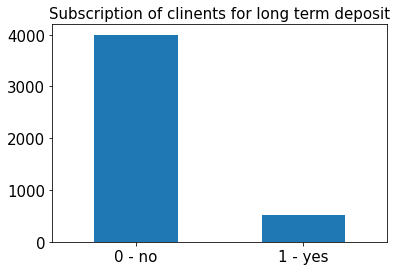

Target y is slightly imbalanced


In [8]:
# check y (target) imbalance
ax=y.groupby(['y'])['y'].count().plot.bar()
ax.set_xticklabels(['0 - no','1 - yes'], rotation=0)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('')
ax.set_title ('Subscription of clinents for long term deposit', fontsize=15)
plt.show()
print('Target y is slightly imbalanced')

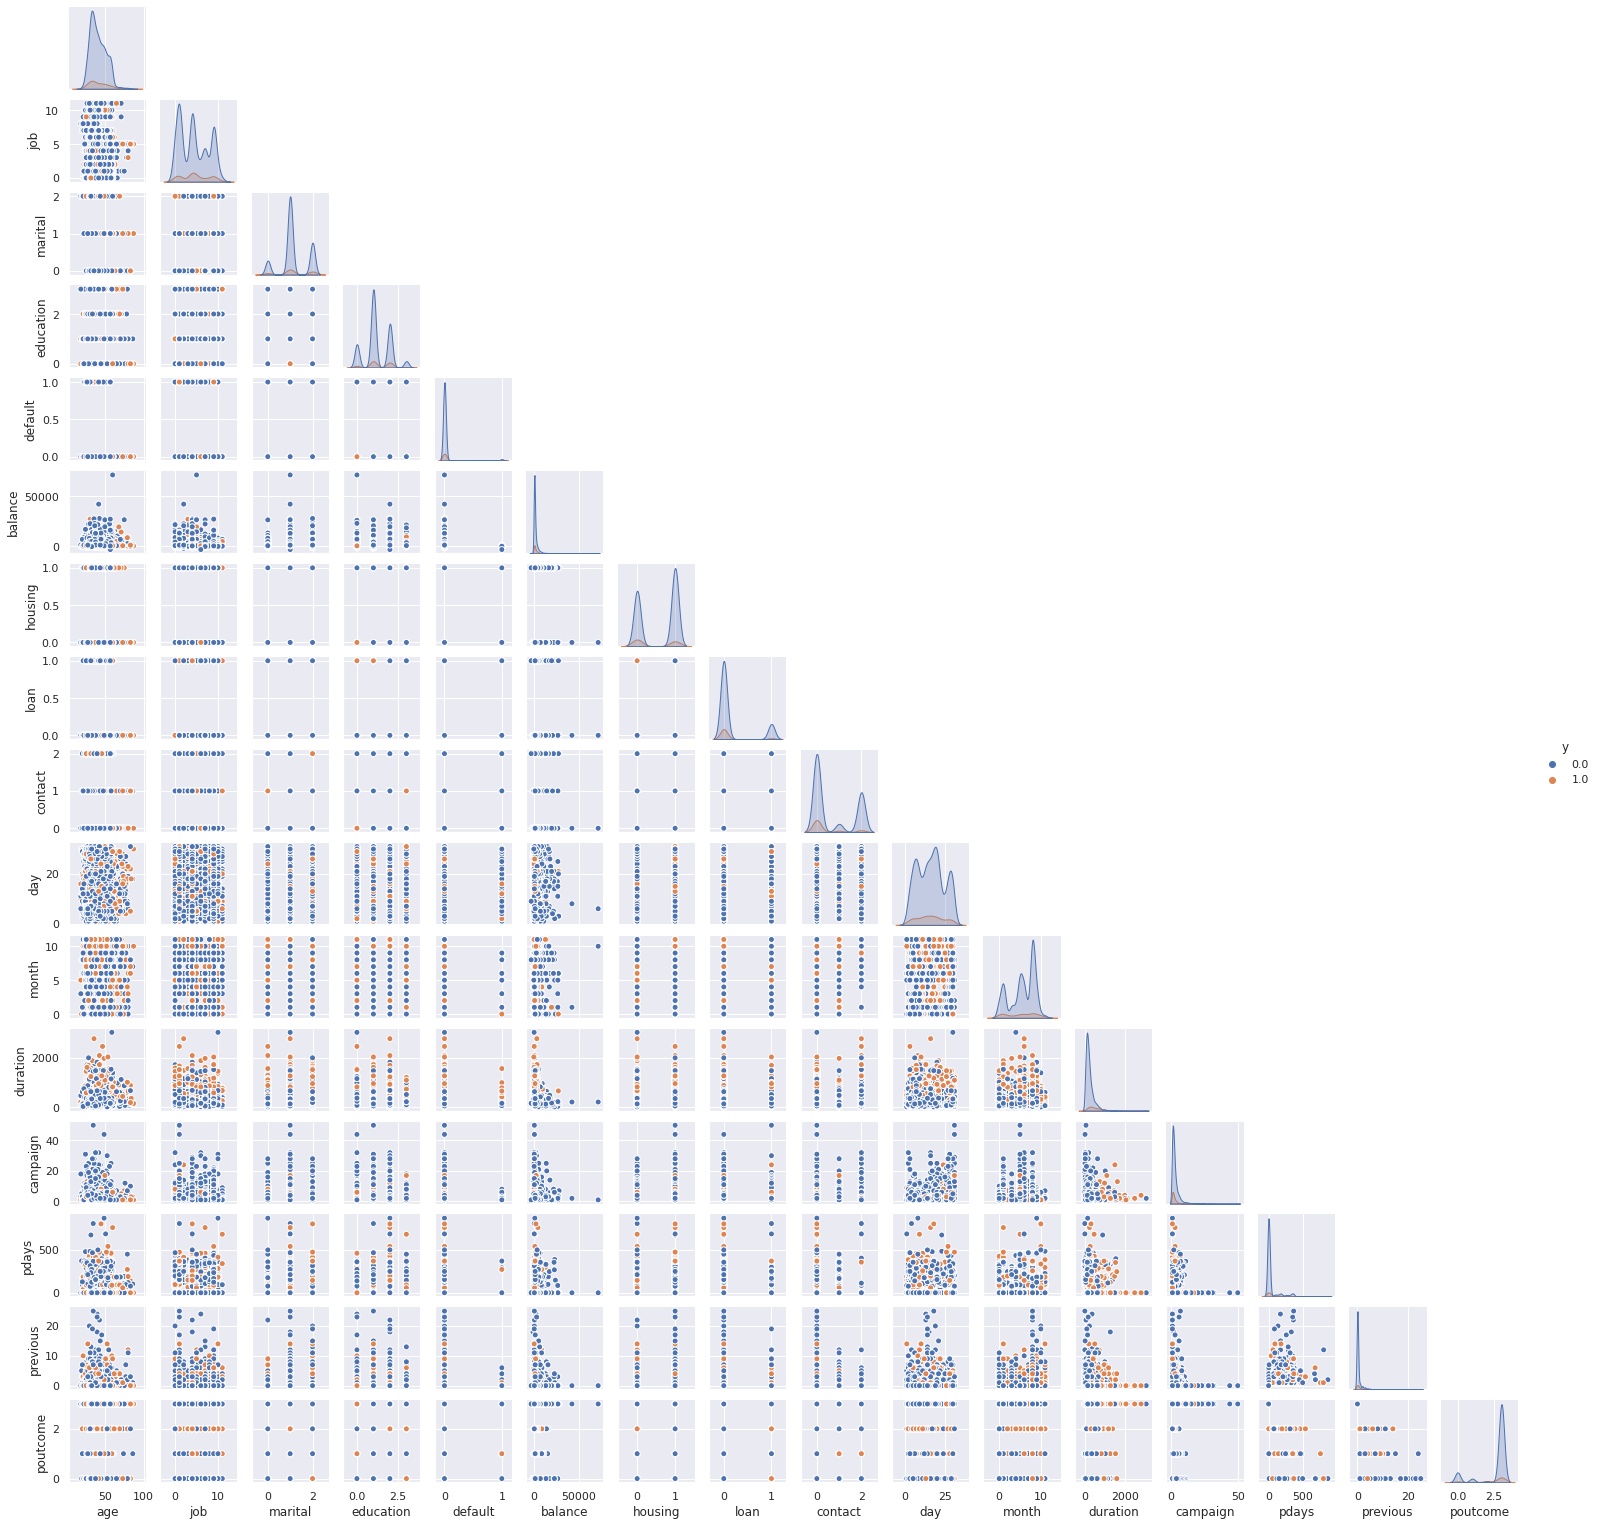

In [9]:
# check relashionship between variables and distributions
sns.set(font_scale=1) 
data_num = all_table.select_dtypes(include=np.number)
sns.pairplot(data_num, height=1.35, plot_kws=dict(linewidth=1, color='c'), corner=True, hue="y")

In [10]:
# removing outliers
#all_table_new = all_table
#all_table_0 = all_table.loc[all_table.y==0]
#remove_outliers_columns = ['campaign', 'balance', 'duration', 'pdays']

#for col in remove_outliers_columns:
        #std = all_table_0[col].std()
        #ave = all_table_0[col].mean()
        #all_table_0 = all_table_0.loc[(all_table_0[col]>ave-3*std)&(all_table_0[col]<ave+3*std)]
        #print(f'processing {col:10} --> {all_table_0.shape[0]:5} clinents remain')

In [11]:
# removing outliers
remove_outliers_columns = ['campaign', 'balance', 'duration', 'pdays']
all_table_new = all_table
#all_table_0 = all_table.loc[all_table.y==0]

for col in remove_outliers_columns:
        std = all_table_new[col].std()
        ave = all_table_new[col].mean()
        all_table_new = all_table_new.loc[(all_table_new[col]>ave-2*std)&(all_table_new[col]<ave+2*std)]
        print(f'processing {col:10} --> {all_table_new.shape[0]:5} clinents remain')

processing campaign   -->  4364 clinents remain
processing balance    -->  4204 clinents remain
processing duration   -->  4008 clinents remain
processing pdays      -->  3691 clinents remain


In [12]:
#all_table_0.head()
all_table_new.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79.00,1,-1.00,0,3,0.00
3,30,4,1,2,0,1476,1,1,2,3,6,199.00,4,-1.00,0,3,0.00
4,59,1,1,1,0,0,1,0,2,5,8,226.00,1,-1.00,0,3,0.00
5,35,4,2,2,0,747,0,0,0,23,3,141.00,2,176.00,3,0,0.00
7,39,9,1,1,0,147,1,0,0,6,8,151.00,2,-1.00,0,3,0.00


In [13]:
# number of clients with y=0 (no subsciption)
all_table_new.shape[0]

3691

In [14]:
#merge target y=0 with target y=1
#table_after_remove_outliers = pd.concat([all_table_0, all_table.loc[all_table.y==1]], axis=0)
table_after_remove_outliers = all_table_new

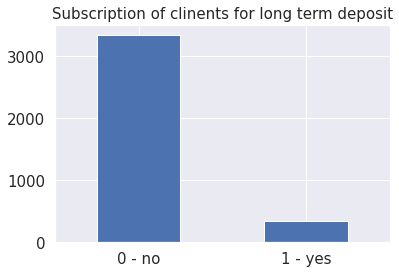

Target y is slightly imbalanced!


In [15]:
# check y (target) imbalance
ax=table_after_remove_outliers.groupby(['y'])['y'].count().plot.bar()
ax.set_xticklabels(['0 - no','1 - yes'], rotation=0)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('')
ax.set_title ('Subscription of clinents for long term deposit', fontsize=15)
plt.show()
print('Target y is slightly imbalanced!')

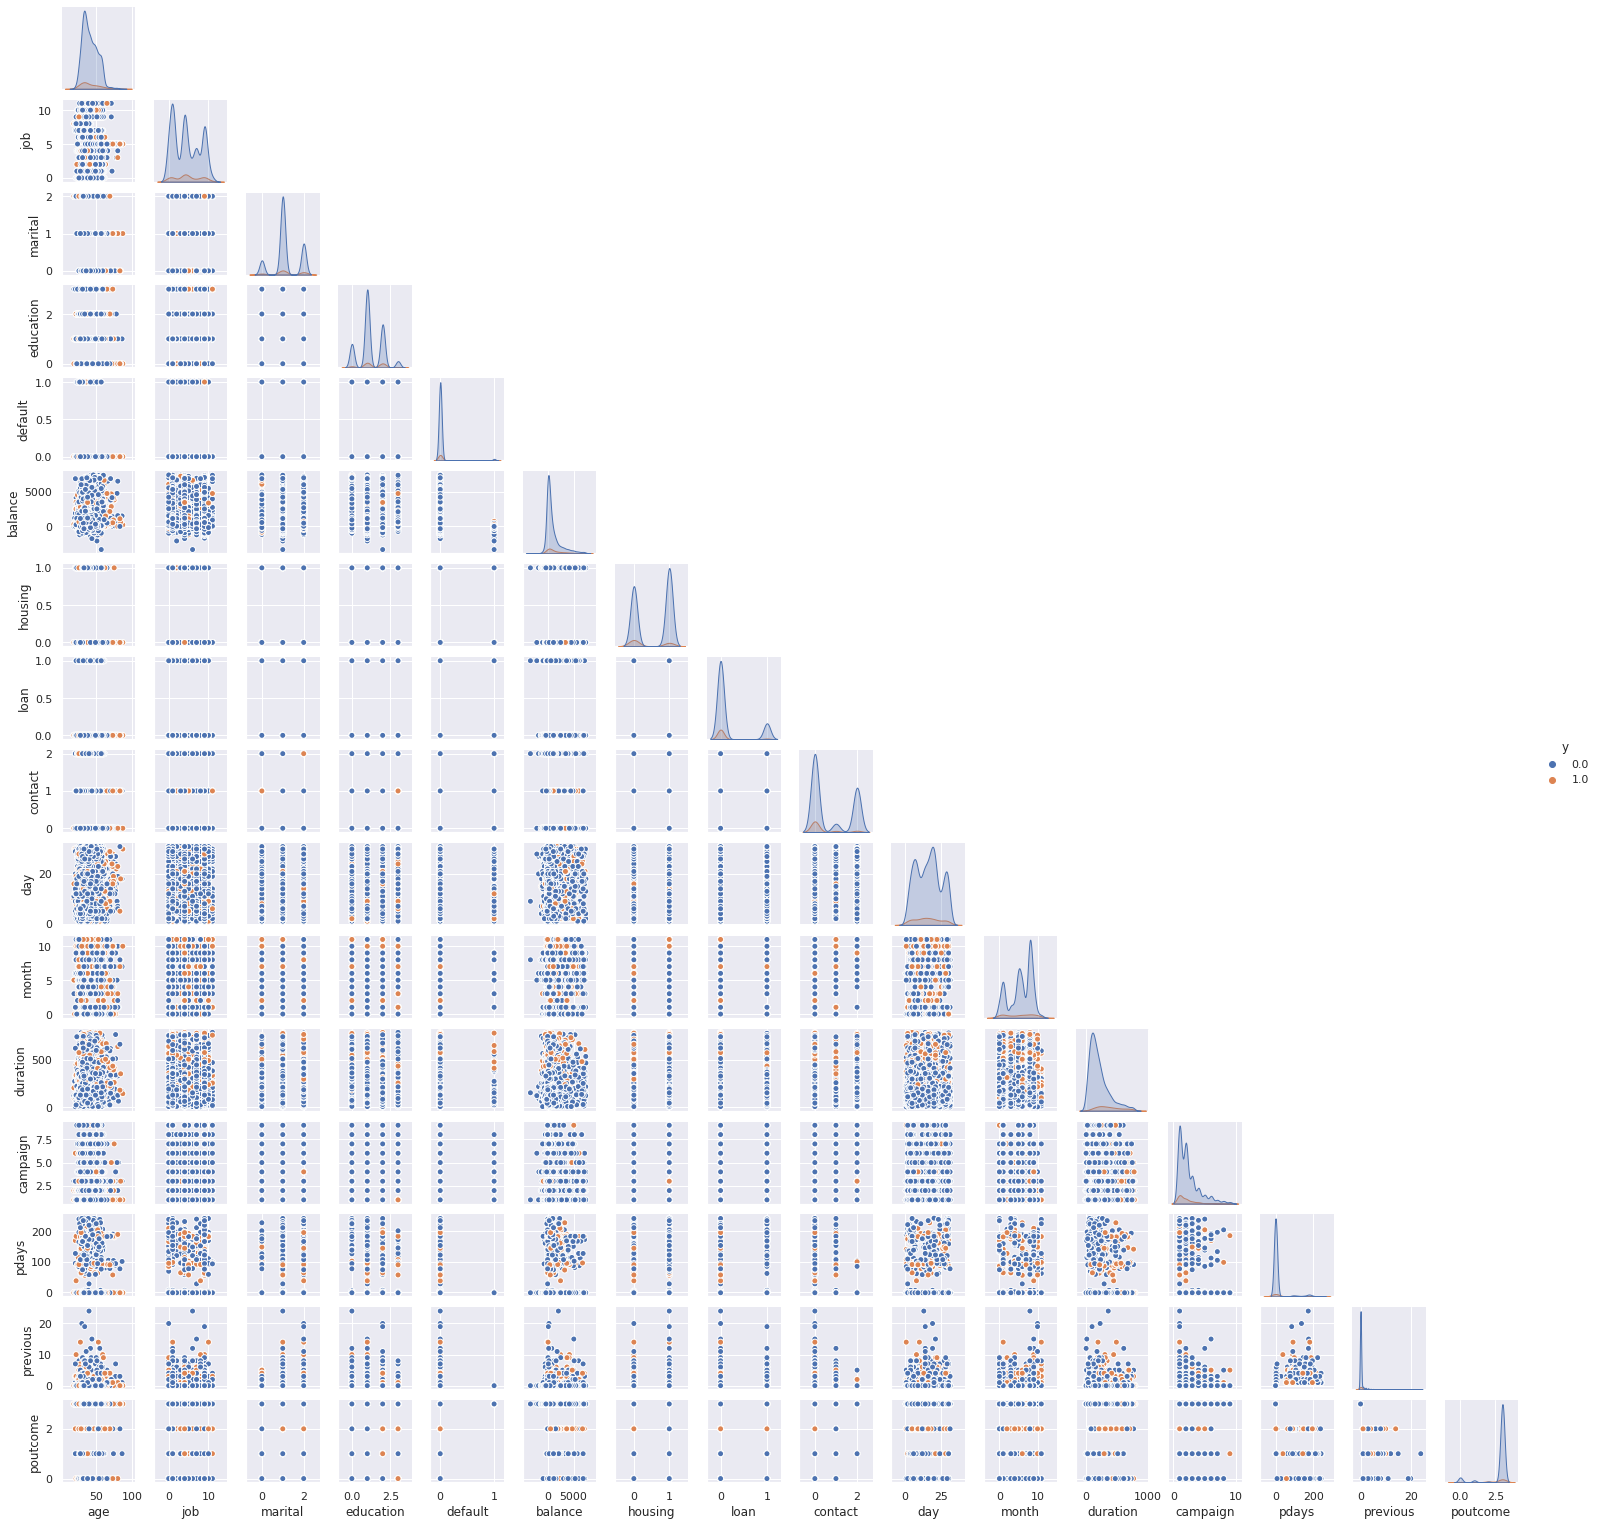

In [16]:
# check relashionship between variables and distributions after removing outliers 
sns.set(font_scale=1) 
data_num = table_after_remove_outliers.select_dtypes(include=np.number)
sns.pairplot(data_num, height=1.35, plot_kws=dict(linewidth=1, color='c'), corner=True, hue="y")

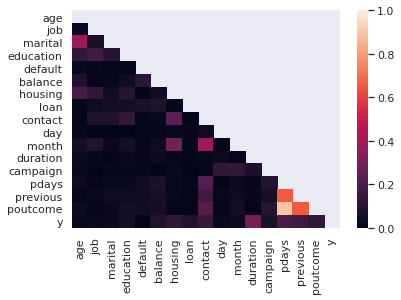

In [17]:
#correlation matrix

sns.heatmap(table_after_remove_outliers.corr(method='pearson').abs(), mask=np.triu(np.ones_like(table_after_remove_outliers.corr().abs(), dtype=bool)), vmin=0, vmax=1)


1. Assuming the analysis is month basis --> remove day column?
2. Duration is moderately correlated with the target y
3. pdays is highy correlated with both previous and poutcome --> remove pdays

In [18]:
table_after_remove_outliers = table_after_remove_outliers.drop(['pdays'], axis=1)
table_after_remove_outliers

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79.00,1,0,3,0.00
3,30,4,1,2,0,1476,1,1,2,3,6,199.00,4,0,3,0.00
4,59,1,1,1,0,0,1,0,2,5,8,226.00,1,0,3,0.00
5,35,4,2,2,0,747,0,0,0,23,3,141.00,2,3,0,0.00
7,39,9,1,1,0,147,1,0,0,6,8,151.00,2,0,3,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4514,38,1,1,1,0,1205,1,0,0,20,0,45.00,4,1,0,0.00
4515,32,7,2,1,0,473,1,0,0,7,5,624.00,5,0,3,0.00
4516,33,7,1,1,0,-333,1,0,0,30,5,329.00,5,0,3,0.00
4517,57,6,1,2,1,-3313,1,1,2,9,8,153.00,1,0,3,0.00


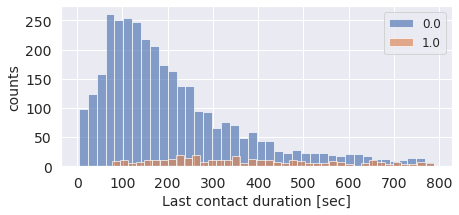

In [19]:
list_of_features = ['duration']

hue_param=table_after_remove_outliers.groupby('y')

plt.figure(figsize=(7,10))
for i in range(1,2):
  for name, group in hue_param:
      plt.subplot(3,1,i)
      ax=plt.hist(group[list_of_features[i-1]],label=name, alpha= .65, bins=40)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Last contact duration [sec]', fontsize = 14)
plt.ylabel('counts', fontsize = 14)
plt.legend(fontsize=12)

In [20]:
print(table_after_remove_outliers.loc[table_after_remove_outliers.y==0].shape[0])
table_after_remove_outliers.loc[table_after_remove_outliers.y==1].shape[0]

3341


350

In [21]:
y_0_under_sample= table_after_remove_outliers.loc[table_after_remove_outliers.y==0].sample(frac=0.1, replace=False)
y_0_under_sample.shape[0]



334

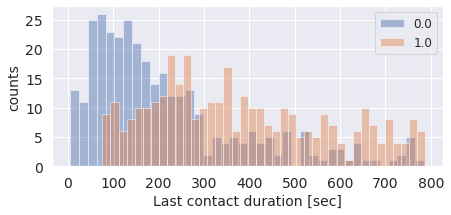

In [22]:
# duration feature histogram with Balanced y target

list_of_features = ['duration']
balanced_table = pd.concat([y_0_under_sample, table_after_remove_outliers.loc[table_after_remove_outliers.y==1]], axis=0 )

hue_param=balanced_table.groupby('y')

plt.figure(figsize=(7,10))
for i in range(1,2):
  for name, group in hue_param:
      plt.subplot(3,1,i)
      ax=plt.hist(group[list_of_features[i-1]],label=name, alpha= .45, bins=40)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Last contact duration [sec]', fontsize = 14)
plt.ylabel('counts', fontsize = 14)
plt.legend(fontsize=12)

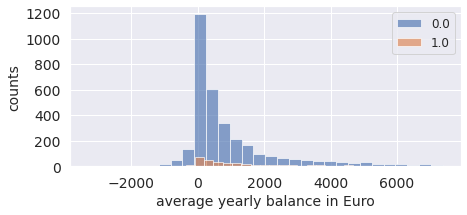

In [23]:
list_of_features = ['balance']

hue_param=table_after_remove_outliers.groupby('y')

plt.figure(figsize=(7,10))
for i in range(1,2):
  for name, group in hue_param:
      plt.subplot(3,1,i)
      ax=plt.hist((group[list_of_features[i-1]]),label=name, alpha= .65,bins=30)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('average yearly balance in Euro', fontsize = 14)
plt.ylabel('counts', fontsize = 14)
plt.legend(fontsize=12)

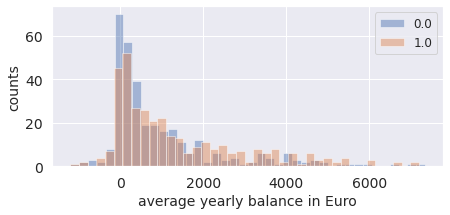

In [24]:
# balance feature histogram with Balanced y target
list_of_features = ['balance']
balanced_table = pd.concat([y_0_under_sample, table_after_remove_outliers.loc[table_after_remove_outliers.y==1]], axis=0 )

hue_param=balanced_table.groupby('y')

plt.figure(figsize=(7,10))
for i in range(1,2):
  for name, group in hue_param:
      plt.subplot(3,1,i)
      ax=plt.hist(group[list_of_features[i-1]],label=name, alpha= .45, bins=40)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('average yearly balance in Euro', fontsize = 14)
plt.ylabel('counts', fontsize = 14)
plt.legend(fontsize=12)

In [25]:
table_after_remove_outliers.loc[table_after_remove_outliers.y==1].groupby('month')['y'].count()

month
0     40
1     50
2      6
3     34
4     11
5     28
6     38
7     19
8     47
9     30
10    33
11    14
Name: y, dtype: int64

In [26]:
table_after_remove_outliers.loc[table_after_remove_outliers.y==1].groupby('month')['campaign'].sum()

month
0      68
1     134
2      15
3      69
4      18
5      71
6      82
7      36
8      93
9      48
10     44
11     24
Name: campaign, dtype: int64

**Business questions:**

In [27]:
number_y= table_after_remove_outliers['y'].value_counts()[1]
number_y

350

Text(0.5, 1.0, 'Percentage of clients per day')

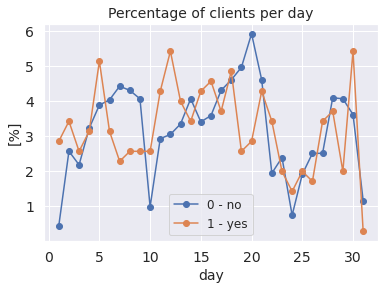

In [28]:
for i in range(0,2):

  number_y= table_after_remove_outliers['y'].value_counts()[i]
  ax=table_after_remove_outliers.loc[table_after_remove_outliers['y']==i].groupby(['day'])['y'].count().apply(lambda x: (x/number_y)*100).plot(marker='o')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('day', fontsize = 14)
plt.ylabel('[%]', fontsize = 14)
plt.legend(['0 - no', '1 - yes'], fontsize=12)
plt.title('Percentage of clients per day', fontsize=14)


Text(0.5, 1.0, 'Percentage of clients per month')

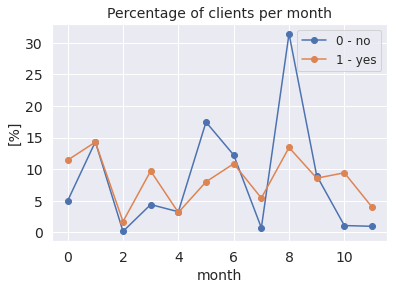

In [29]:
for i in range(0,2):

  number_y= table_after_remove_outliers['y'].value_counts()[i]
  ax=table_after_remove_outliers.loc[table_after_remove_outliers['y']==i].groupby(['month'])['y'].count().apply(lambda x: (x/number_y)*100).plot(marker='o')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('month', fontsize = 14)
plt.ylabel('[%]', fontsize = 14)
plt.legend(['0 - no', '1 - yes'], fontsize=12)
plt.title('Percentage of clients per month', fontsize=14)

Text(0.5, 1.0, 'number of campigns over the year')

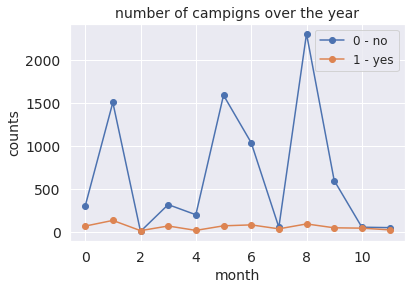

In [30]:
#number of campaings over the years
ax=table_after_remove_outliers.loc[table_after_remove_outliers.y==0].groupby('month')['campaign'].sum().plot(marker='o')
table_after_remove_outliers.loc[table_after_remove_outliers.y==1].groupby('month')['campaign'].sum().plot(marker='o', ax=ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('month', fontsize = 14)
plt.ylabel('counts', fontsize = 14)
plt.legend(['0 - no', '1 - yes'], fontsize=12)
plt.title('number of campigns over the year', fontsize=14)

Text(0.5, 1.0, 'number of campaigns per client over the year')

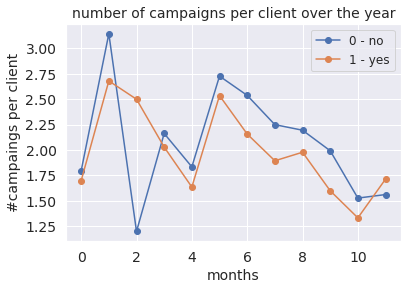

In [31]:
#number of campaings per clinent over the years

for i in range(0,2):
  count_campaing = table_after_remove_outliers.loc[table_after_remove_outliers.y==i].groupby('month')['campaign'].sum()
  count_y = table_after_remove_outliers.loc[table_after_remove_outliers.y==i].groupby('month')['y'].count()

  num_campaings_per_client = count_campaing/count_y

  ax= plt.plot(num_campaings_per_client, marker='o')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('months', fontsize = 14)
plt.ylabel('#campaings per client', fontsize = 14)
plt.legend(['0 - no', '1 - yes'], fontsize=12)
plt.title('number of campaigns per client over the year', fontsize=14)



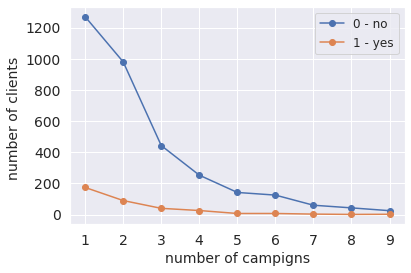

In [32]:
# number of clients  versus number of campaings
ax=table_after_remove_outliers.loc[table_after_remove_outliers.y==0].groupby('campaign')['y'].count().plot(marker='o')
table_after_remove_outliers.loc[table_after_remove_outliers.y==1].groupby('campaign')['y'].count().plot(marker='o', ax=ax)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('number of campigns', fontsize = 14)
plt.ylabel('number of clients ', fontsize = 14)
plt.legend(['0 - no', '1 - yes'], fontsize=12)



**more pre processing:**
Remove clients where "poutcome" feature is set to either unknown or other

In [33]:
# remove other and unknown {'0': 'failure', '1': 'other', '2': 'success', '3': 'unknown'}
table_after_remove_outliers.poutcome.loc[(table_after_remove_outliers.poutcome==1) | (table_after_remove_outliers.poutcome==3)].value_counts()

3    3274
1      98
Name: poutcome, dtype: int64

In [34]:
# create table with 'poutcome' = failure or success
new_table = table_after_remove_outliers.copy()
new_table = table_after_remove_outliers.loc[(table_after_remove_outliers.poutcome==0) | (table_after_remove_outliers.poutcome==2)]
new_table.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
5,35,4,2,2,0,747,0,0,0,23,3,141.00,2,3,0,0.00
9,43,7,1,0,0,-88,1,1,0,17,0,313.00,1,2,0,0.00
14,31,1,1,1,0,360,1,1,0,29,4,89.00,1,1,0,0.00
17,37,0,2,2,0,2317,1,0,0,20,0,114.00,1,2,0,0.00
27,67,5,1,3,0,696,0,0,1,17,1,119.00,1,2,0,0.00


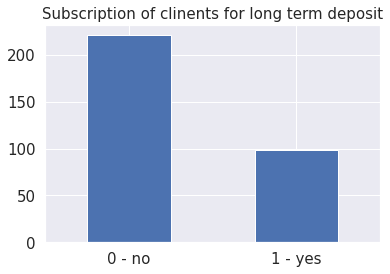

Target y is more balanced :)


In [35]:
# check y (target) imbalance
ax=new_table.groupby(['y'])['y'].count().plot.bar()
ax.set_xticklabels(['0 - no','1 - yes'], rotation=0)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('')
ax.set_title ('Subscription of clinents for long term deposit', fontsize=15)
plt.show()
print('Target y is more balanced :)')

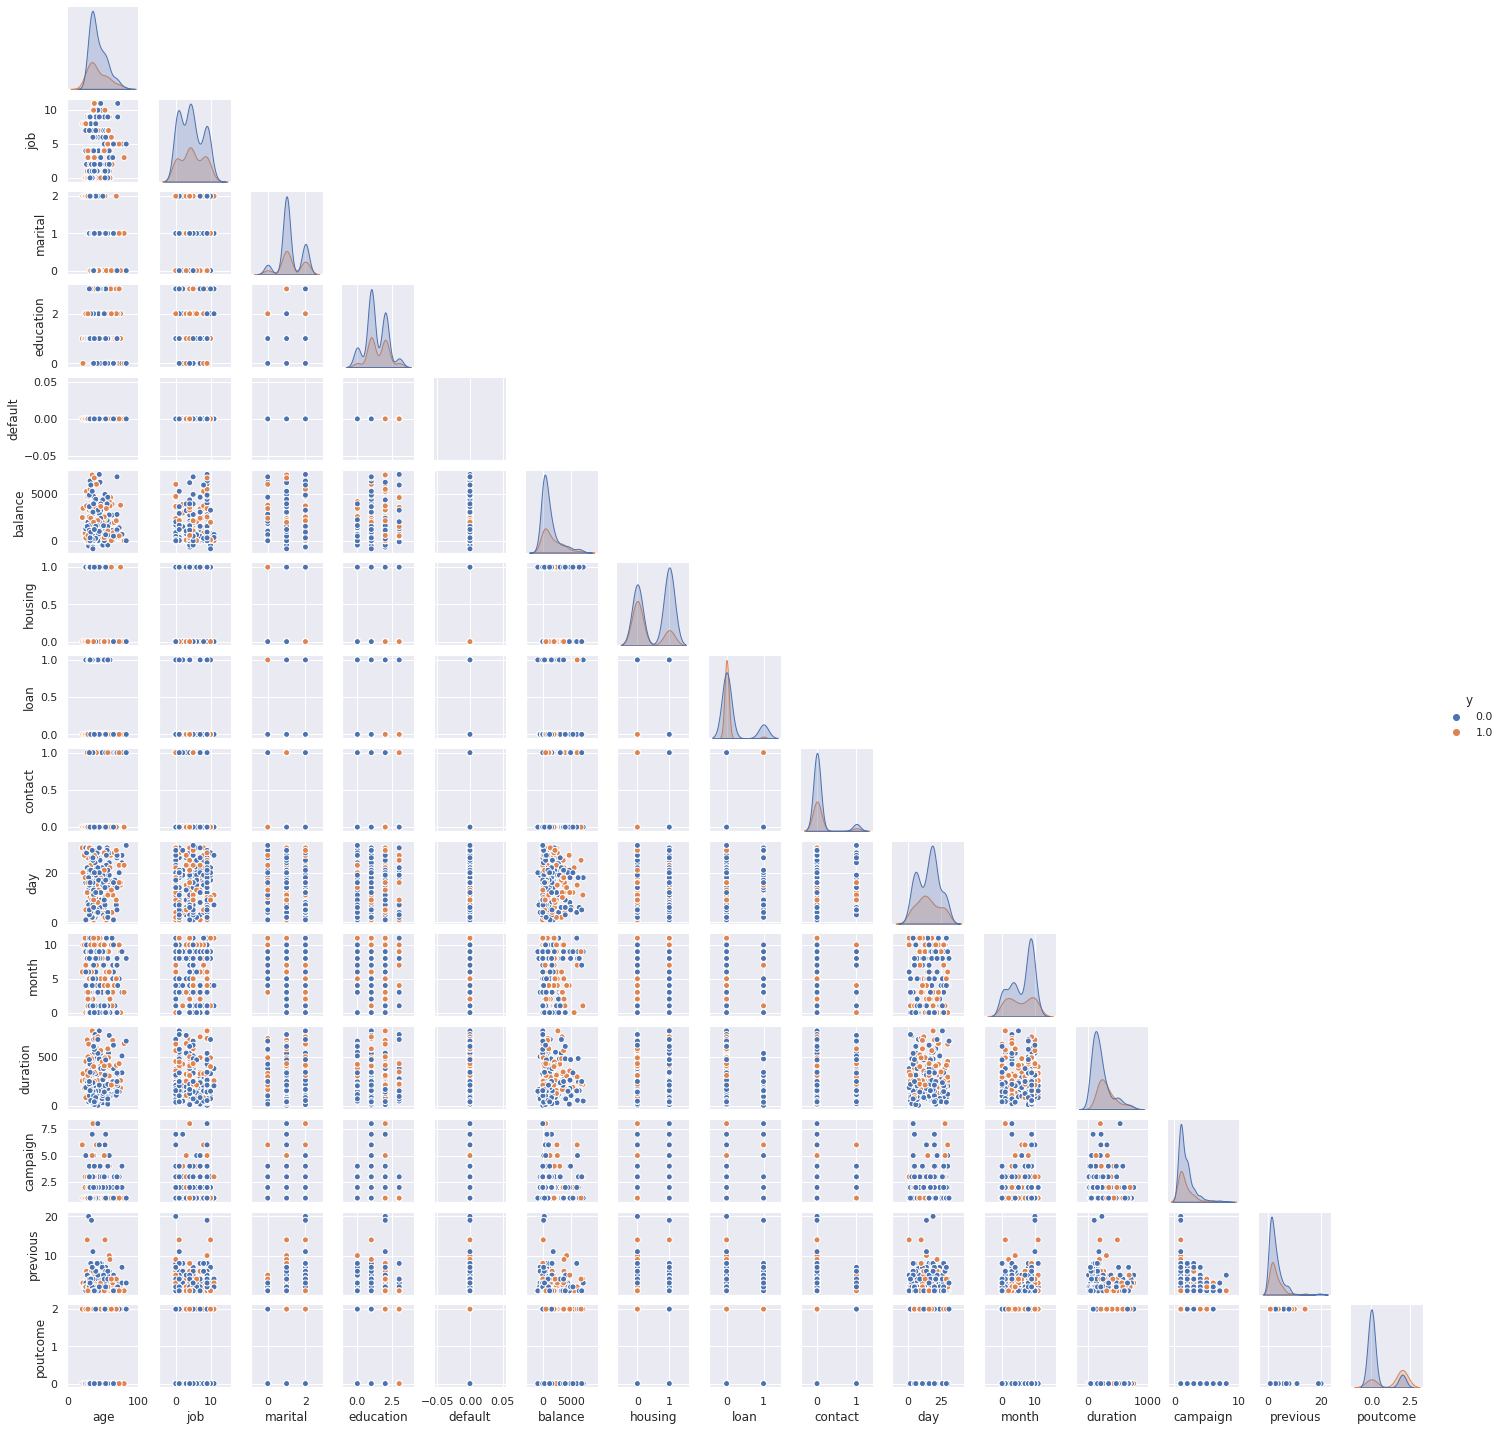

In [36]:
# check relashionship between variables and distributions (after removing outliers) for poutcome = failure or success
sns.set(font_scale=1) 
data_num = new_table.select_dtypes(include=np.number)
sns.pairplot(data_num, height=1.35, plot_kws=dict(linewidth=1, color='c'), corner=True, hue="y")

In [37]:
new_table.default.unique()

array([0])

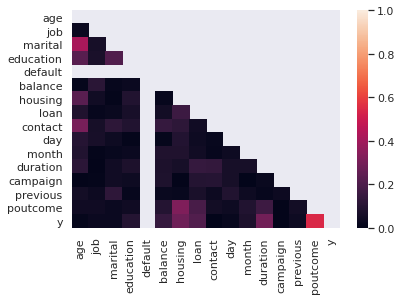

In [38]:
#correlation matrix

sns.heatmap(new_table.corr(method='pearson').abs(), mask=np.triu(np.ones_like(new_table.corr().abs(), dtype=bool)), vmin=0, vmax=1)


most of the clients are married or single


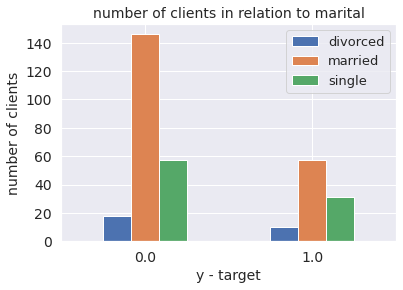

In [39]:
ax=new_table.groupby(['y','marital'])['marital'].count().unstack(1).plot.bar()
plt.xticks(rotation=0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('y - target', fontsize = 14)
plt.ylabel('number of clients', fontsize = 14)
plt.title('number of clients in relation to marital', fontsize=14)
plt.legend(['divorced', 'married', 'single' ], fontsize=13)
print('most of the clients are married or single')

In [40]:
# change divorced status to married
old_customers_table = new_table.copy()
old_customers_table['marital'] = new_table['marital'].replace({0: 1})

maybe consider separate models for failure/sucesses from the previous campaing?


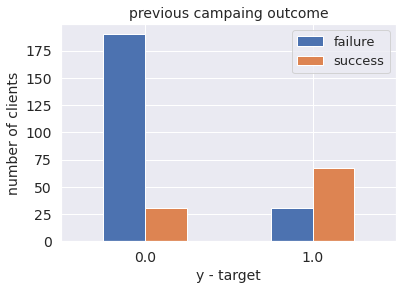

In [41]:
old_customers_table.groupby(['y','poutcome'])['poutcome'].count().unstack(1).plot.bar()
plt.xticks(rotation=0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('y - target', fontsize = 14)
plt.ylabel('number of clients', fontsize = 14)
plt.title('previous campaing outcome', fontsize=14)
plt.legend(['failure', 'success' ], fontsize=13)
print('maybe consider separate models for failure/sucesses from the previous campaing?')


In [42]:
# remove failure and success {'0': 'failure', '1': 'other', '2': 'success', '3': 'unknown'}

new_customers_table = table_after_remove_outliers.copy()
new_customers_table  = table_after_remove_outliers.loc[(table_after_remove_outliers.poutcome==1) | (table_after_remove_outliers.poutcome==3)]
new_customers_table['marital'] = new_customers_table['marital'].replace({0: 1})
new_customers_table.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79.00,1,0,3,0.00
3,30,4,1,2,0,1476,1,1,2,3,6,199.00,4,0,3,0.00
4,59,1,1,1,0,0,1,0,2,5,8,226.00,1,0,3,0.00
7,39,9,1,1,0,147,1,0,0,6,8,151.00,2,0,3,0.00
8,41,2,1,2,0,221,1,0,2,14,8,57.00,2,0,3,0.00


In [43]:
# number of new customers (where the outcome of previous campaign in other or unknown)
new_customers_table.poutcome.value_counts()

3    3274
1      98
Name: poutcome, dtype: int64

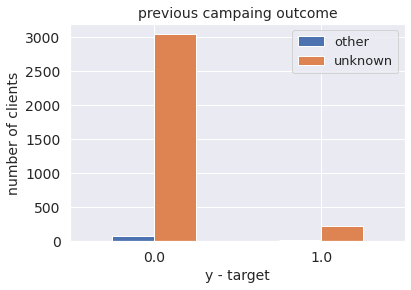

In [44]:
new_customers_table.groupby(['y','poutcome'])['poutcome'].count().unstack(1).plot.bar()
plt.xticks(rotation=0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('y - target', fontsize = 14)
plt.ylabel('number of clients', fontsize = 14)
plt.title('previous campaing outcome', fontsize=14)
plt.legend(['other', 'unknown' ], fontsize=13)

**Modeling approach:**
1. most of the clients which got 'success' in the previous campign success (1) also in the current campaign

2. most of the clients which got 'unknown' in the previous campign got 0 (failure) in the current campaign. All 'other' from the previous campaign got 0 (failure)


model 1: for old customers (got 'failure' or 'success' in the previous campaign)

model 2: for new customers (got 'other' or 'unknown' in the previous campaign)

In [45]:
# Tables to work with:
# 1. model 1: old_customers_table (participated in the previous marketing campaings ---> poutcome is failure or success )
# 2. model 2: new_customers_table (not participated in the previous campaings ---> poutcome is other or unknown)

**Machine** **learning:**
for each model the following will be implemented:
1. boosting of:

  1.1 decision tree 

  2.2 random forest
2. knn
3. *logistic regression seems not to work well due to low linear correlation between the features

In [46]:
# table of old customers:
old_customers_table.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
5,35,4,2,2,0,747,0,0,0,23,3,141.00,2,3,0,0.00
9,43,7,1,0,0,-88,1,1,0,17,0,313.00,1,2,0,0.00
14,31,1,1,1,0,360,1,1,0,29,4,89.00,1,1,0,0.00
17,37,0,2,2,0,2317,1,0,0,20,0,114.00,1,2,0,0.00
27,67,5,1,3,0,696,0,0,1,17,1,119.00,1,2,0,0.00


In [47]:
print(old_customers_table.poutcome.unique())
old_customers_table.default.unique()

[0 2]


array([0])

In [48]:
# drop default feature and get dummies for cathegorical features in old_customers_table
old_customers_table_final = old_customers_table.drop(['default'], axis=1)
old_customers_table_final = pd.get_dummies(old_customers_table_final, 
                                           columns=['job', 'marital','education', 'housing', 'loan', 'contact', 'day','month', 'poutcome'])

In [49]:
old_customers_table_final.head()

,age,balance,duration,campaign,previous,y,job_0,job_1,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,job_11,marital_1,marital_2,education_0,education_1,education_2,education_3,housing_0,housing_1,loan_0,loan_1,contact_0,contact_1,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,poutcome_0,poutcome_2
5,35,747,141.00,2,3,0.00,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
9,43,-88,313.00,1,2,0.00,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
14,31,360,89.00,1,1,0.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
17,37,2317,114.00,1,2,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
27,67,696,119.00,1,2,0.00,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [50]:
old_customers_table_final.shape

(319, 75)

In [51]:
# table of new customers:
new_customers_table.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79.00,1,0,3,0.00
3,30,4,1,2,0,1476,1,1,2,3,6,199.00,4,0,3,0.00
4,59,1,1,1,0,0,1,0,2,5,8,226.00,1,0,3,0.00
7,39,9,1,1,0,147,1,0,0,6,8,151.00,2,0,3,0.00
8,41,2,1,2,0,221,1,0,2,14,8,57.00,2,0,3,0.00


In [52]:
print(new_customers_table.poutcome.unique())
new_customers_table.default.unique()

[3 1]


array([0, 1])

In [53]:
# get dummies for cathegorical features in new_customers_table
new_customers_table_final = pd.get_dummies(new_customers_table, columns=['job', 'marital','education', 'housing', 'loan', 'contact', 'day','month', 'poutcome'])
new_customers_table_final.head()

,age,default,balance,duration,campaign,previous,y,job_0,job_1,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,job_11,marital_1,marital_2,education_0,education_1,education_2,education_3,housing_0,housing_1,loan_0,loan_1,contact_0,contact_1,contact_2,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,poutcome_1,poutcome_3
0,30,0,1787,79.00,1,0,0.00,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,30,0,1476,199.00,4,0,0.00,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,59,0,0,226.00,1,0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
7,39,0,147,151.00,2,0,0.00,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
8,41,0,221,57.00,2,0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [54]:
new_customers_table_final.shape

(3372, 77)

In [55]:
X_old = old_customers_table_final.drop(['y'], axis=1)
y_old = old_customers_table_final['y']



In [56]:
X_train_old, X_test_old, y_train_old, y_test_old = \
    train_test_split(X_old, y_old, test_size=0.2, random_state=107)

**Desicion tree and random forest for "old_customers_table_final"** (for the old customers who participated in the previous campaign)

In [57]:
class predictions:

  def __init__(self, X_train_old, y_train_old, X_test_old, y_test_old):
    
      self.X_train_old = X_train_old
      self.y_train_old = y_train_old
      self.X_test_old = X_test_old
      self.y_test_old = y_test_old

  def GridSearch(self):
    
      "return: best decision tree hyperparameters by grid search"

      clf_old = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 5)

      # define tree classifier and grid parameters
      #weights = [0.05, 0.06, 0.07, 0.08, 0.09]
      weights = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4]
      my_param_grid = [{'max_depth': list(range(4,7)), 'max_leaf_nodes': list(range(8,128,10)), 
                        'class_weight': [{0: x, 1: 1.0-x} for x in weights]}]

      # search for the best hyper parameters
      clf_gs_old = GridSearchCV(clf_old, my_param_grid, cv=5)
      clf_gs_old.fit(self.X_train_old, self.y_train_old)

      # class weights
      self.w_neg = clf_gs_old.best_params_['class_weight'][0]
      self.w_pos = clf_gs_old.best_params_['class_weight'][1]

      # max depth tree
      self.max_depth_tree = clf_gs_old.best_params_['max_depth']

      # max leaf nodes tree
      self. max_leaf_nodes_tree = clf_gs_old.best_params_['max_leaf_nodes']

      return self

  def fit_predict_boost_tree(self):

      self.base_estimator = DecisionTreeClassifier(max_depth=self.max_depth_tree, 
                                                  criterion='entropy', 
                                                  min_samples_leaf=5,  
                                                  max_leaf_nodes=self. max_leaf_nodes_tree, 
                                                  random_state=111, 
                                                  class_weight={0: self.w_neg, 1: self.w_pos})
      
      self.clf_adaboost = AdaBoostClassifier(base_estimator=self.base_estimator, learning_rate=0.01, random_state=111)
      
      self.y_pred_train = self.clf_adaboost.fit(self.X_train_old, self.y_train_old).predict(self.X_train_old)
      self.y_pred_test = self.clf_adaboost.predict(self.X_test_old)

      return self

  def fit_predict_boost_RandomForest(self):

      self.rf_model = RandomForestClassifier(max_depth=self.max_depth_tree, 
                                            n_estimators=60, 
                                            criterion='entropy', 
                                            min_samples_leaf=5,  
                                            max_leaf_nodes=self. max_leaf_nodes_tree, 
                                            random_state=111, 
                                            class_weight={0: self.w_neg, 1: self.w_pos})

      self.clf_adaboost = AdaBoostClassifier(self.rf_model, 
                                            n_estimators=20, 
                                            learning_rate=0.01, random_state=111)
      
      self.y_pred_train = self.clf_adaboost.fit(self.X_train_old, self.y_train_old).predict(self.X_train_old)
      self.y_pred_test = self.clf_adaboost.predict(self.X_test_old)

      return self

  def fit_predict_knnClassifier(self, n_neighbors, weights):

      self.knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
      self.y_pred_train = self.knn_model.fit(self.X_train_old, self.y_train_old).predict(self.X_train_old)
      self.y_pred_test = self.knn_model.predict(self.X_test_old)

      return self


  def confusion_matrix(self):

      try:
        self.cm_train = pd.DataFrame(confusion_matrix(y_true=self.y_train_old,
                          y_pred=self.y_pred_train), index=self.clf_adaboost.classes_, 
                          columns=self.clf_adaboost.classes_)
        
        self.cm_test = pd.DataFrame(confusion_matrix(y_true=self.y_test_old,
                          y_pred=self.y_pred_test), index=self.clf_adaboost.classes_, 
                          columns=self.clf_adaboost.classes_)
      except:
        pass
      
      try:

        self.cm_train = pd.DataFrame(confusion_matrix(y_true=self.y_train_old,
                            y_pred=self.y_pred_train), index=self.knn_model.classes_, 
                            columns=self.knn_model.classes_)
          
        self.cm_test = pd.DataFrame(confusion_matrix(y_true=self.y_test_old,
                            y_pred=self.y_pred_test), index=self.knn_model.classes_, 
                            columns=self.knn_model.classes_)
      except:
        pass
      
      return self, print(self.cm_test)

  def Classification_Report(self):

      return print(classification_report(y_true=self.y_test_old,
                              y_pred=self.y_pred_test))
    
  def roc_curve(self):

      self.yprob = self.clf_adaboost.predict_proba(self.X_test_old)
      client_status=['0 - no client subscription', '1 - client subscription']

      for i in range(0,2):
        self.fpr, self.tpr, self.thresholds = metrics.roc_curve(self.y_test_old, self.yprob[:, i], pos_label=i)
        metrics.plot_roc_curve(self.clf_adaboost, self.X_test_old, self.y_test_old, self.yprob[:, i])
        plt.title('roc curve for {}'.format(client_status[i]), fontsize=15)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel('False positive rate',fontsize=14)
        plt.ylabel('True positive rate', fontsize=14)
        plt.show()   


      0.00  1.00
0.00    41     4
1.00     8    11
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87        45
         1.0       0.73      0.58      0.65        19

    accuracy                           0.81        64
   macro avg       0.79      0.75      0.76        64
weighted avg       0.81      0.81      0.81        64



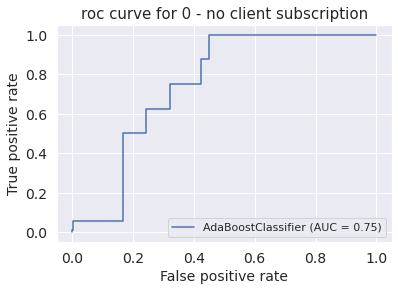

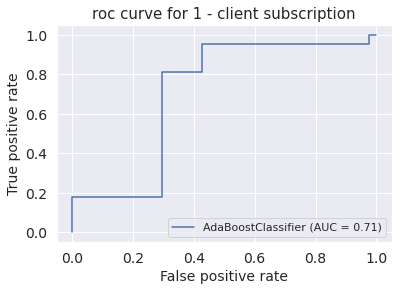

In [58]:
# predict success or failure of old customers in the current campaign using boosted decision tree

old_customers_prediction = predictions(X_train_old, y_train_old, X_test_old, y_test_old)
old_customers_prediction.GridSearch()
old_customers_prediction.fit_predict_boost_tree()
old_customers_prediction.confusion_matrix()
old_customers_prediction.Classification_Report()
old_customers_prediction.roc_curve()


In [59]:
# decision tree estimator using gridsearch parameters
old_customers_prediction.base_estimator

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.4, 1: 0.6},
                       criterion='entropy', max_depth=4, max_features=None,
                       max_leaf_nodes=8, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=111, splitter='best')

In [60]:
# convert float y target to str (for tree visualization)
tree_classes = old_customers_prediction.clf_adaboost.classes_
tree_classes = [int(i) for i in list(tree_classes)]
tree_classes_str = [str(i) for i in tree_classes]
tree_classes_str 

def visualize_tree(model, md=old_customers_prediction.max_depth_tree):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train_old.columns, max_depth=md, proportion=True, 
                    class_names=tree_classes_str)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=1000) 



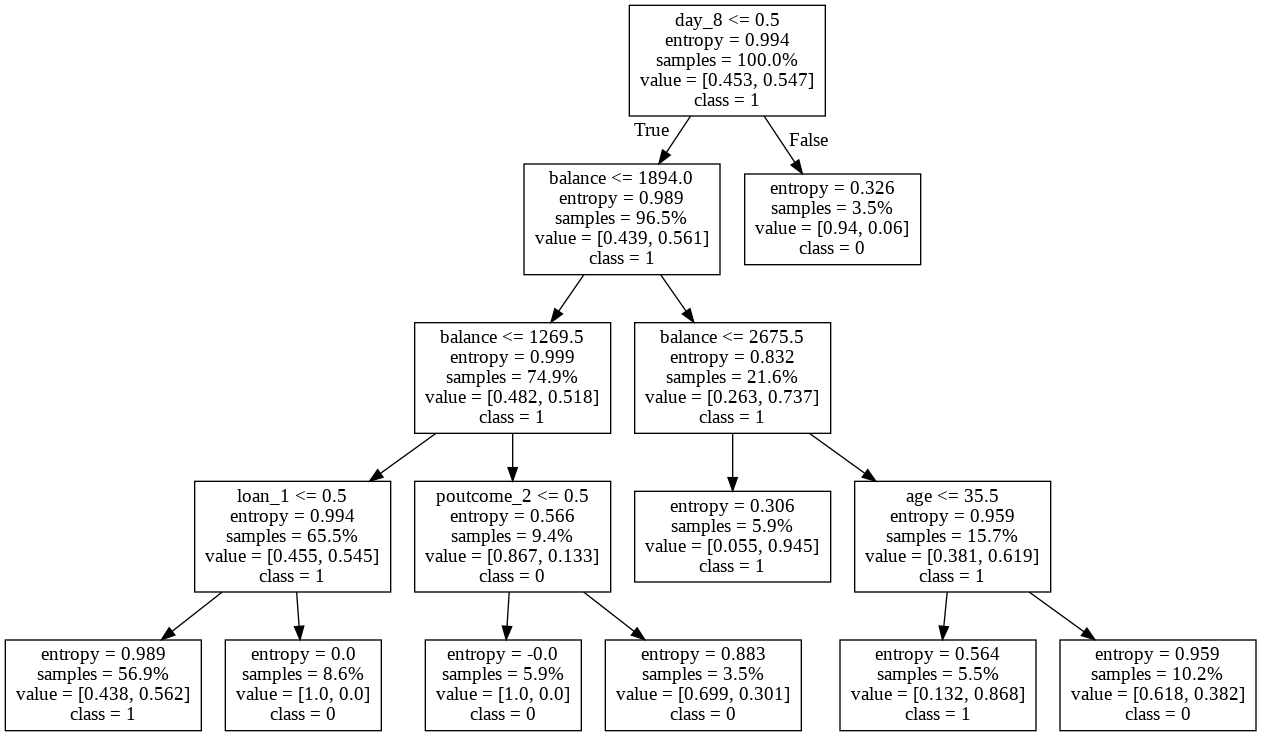

In [61]:
# best decision tree after boosting process
visualize_tree(old_customers_prediction.clf_adaboost[-1], md=old_customers_prediction.max_depth_tree)

Text(0.5, 1.0, 'Features importance')

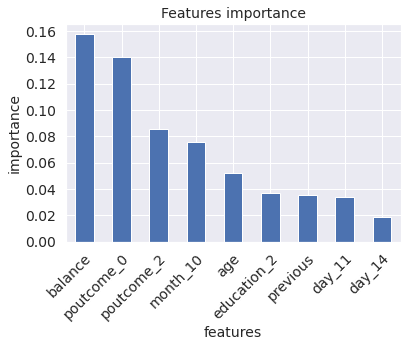

In [62]:
pd.Series(old_customers_prediction.clf_adaboost.feature_importances_,
          index=X_test_old.columns).sort_values(ascending=False).iloc[1:10].plot.bar()
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('features', fontsize = 14)
plt.ylabel('importance', fontsize = 14)
plt.title('Features importance', fontsize=14)


      0.00  1.00
0.00    42     3
1.00     8    11
              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88        45
         1.0       0.79      0.58      0.67        19

    accuracy                           0.83        64
   macro avg       0.81      0.76      0.78        64
weighted avg       0.82      0.83      0.82        64



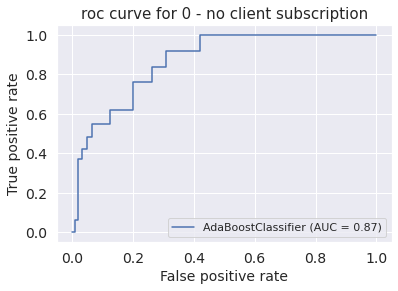

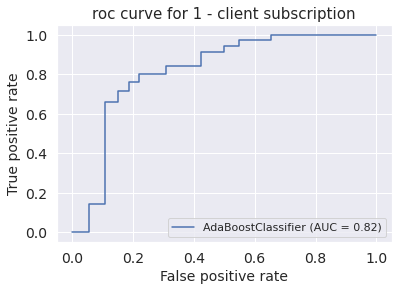

In [63]:
# predict success or failure of old customers in the current campaign using boosted RandomForest

old_customers_prediction = predictions(X_train_old, y_train_old, X_test_old, y_test_old)
old_customers_prediction.GridSearch()
old_customers_prediction.fit_predict_boost_RandomForest()
old_customers_prediction.confusion_matrix()
old_customers_prediction.Classification_Report()
old_customers_prediction.roc_curve()

Text(0.5, 1.0, 'Features importance')

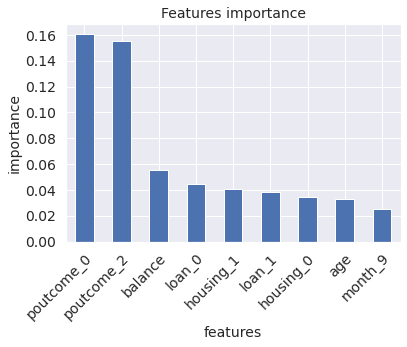

In [64]:
pd.Series(old_customers_prediction.clf_adaboost.feature_importances_,
          index=X_test_old.columns).sort_values(ascending=False).iloc[1:10].plot.bar()
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('features', fontsize = 14)
plt.ylabel('importance', fontsize = 14)
plt.title('Features importance', fontsize=14)

**knn model for new customers** (where the outcome of previous campaign (poutcome) in other or unknown)

In [65]:
X_new = new_customers_table.drop(['y'], axis=1)
y_new = new_customers_table['y']

In [66]:
X_train_new, X_test_new, y_train_new, y_test_new = \
    train_test_split(X_new, y_new, test_size=0.3, random_state=107)

In [67]:
class MyknnModel:
    def __init__(self, n_neighbors_param, weights_param):
      self.knn_model = KNeighborsClassifier(n_neighbors=n_neighbors_param, weights=weights_param)

    def fit(self, X, y):
      self.model_fit = self.knn_model.fit(X, y)
      return self

    def predict(self, X):
      self.y_pred = self.model_fit.predict(X)
      return self

    def score(self, y):
      self.log_loss_knn_opt = log_loss(y_true=y, y_pred=self.y_pred)
      return self

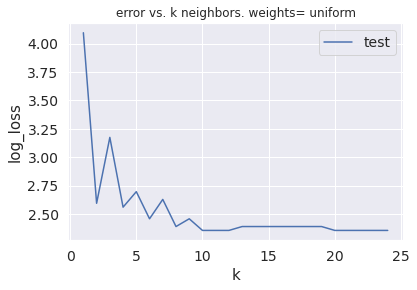

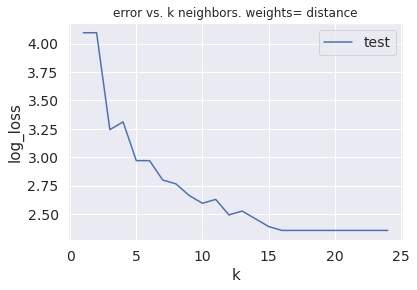

In [68]:
# find the optimal k neighbors by scoring different values for k 

k_numbers = range(1, 25)
weight=['uniform', 'distance']
scores = pd.DataFrame(index=k_numbers, columns=['train', 'test'])

for w,k in enumerate(weight):
  for num_k in k_numbers:
      model_knn = MyknnModel(num_k, k)
      model_knn.fit(X_train_new , y_train_new)
      model_knn.predict(X_train_new)
      model_knn.score(y_train_new)
      scores.loc[num_k, 'train'] = model_knn.log_loss_knn_opt
      #score for test set
      model_knn.predict(X_test_new)
      model_knn.score(y_test_new)
      scores.loc[num_k, 'test'] = model_knn.log_loss_knn_opt

  scores.iloc[:,1].plot()
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.xlabel('k', fontsize=15)
  plt.ylabel('log_loss', fontsize=15)
  plt.legend(fontsize=14)
  plt.title(f'error vs. k neighbors. weights= {weight[w]}')
  plt.show()

In [69]:
scores.head()

,train,test
1,0.00,4.10
2,0.00,4.10
3,0.00,3.24
4,0.00,3.31
5,0.00,2.97


In [70]:
# choose k = 2 for knn model

weights = 'distance'
n_neighbors = 2

new_customers_predictions = predictions(X_train_new, y_train_new, X_test_new, y_test_new)
new_customers_predictions.fit_predict_knnClassifier(n_neighbors, weights)
new_customers_predictions.confusion_matrix()
new_customers_predictions.Classification_Report()
#new_customers_predictions.roc_curve()

      0.00  1.00
0.00   876    67
1.00    53    16
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       943
         1.0       0.19      0.23      0.21        69

    accuracy                           0.88      1012
   macro avg       0.57      0.58      0.57      1012
weighted avg       0.89      0.88      0.89      1012



In [71]:
#cross validation for the knn model

# cross valudation for the original dataset of the new customers
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}


scores_test = cross_val_score(new_customers_predictions.knn_model, X_new, y_new, cv=5)

print("Scores : " + (5 * "{:.3f} ").format(*scores_test))
print(sum(scores_test)/len(scores_test))
print(np.std(scores_test))

Scores : 0.890 0.876 0.877 0.902 0.880 
0.8849359270249477
0.010028027172151685


Balancing train-test sets new customers for the knn model

In [88]:
clients_new_0 =new_customers_table. loc[new_customers_table.y==0]
clients_new_1 =new_customers_table. loc[new_customers_table.y==1]

In [89]:
print(clients_new_1.shape)
clients_new_1_X = clients_new_1.drop(['y'], axis=1)
clients_new_1_y = clients_new_1['y']

(252, 16)


In [90]:
print(clients_new_0.shape)
clients_new_0_X = clients_new_0.drop(['y'], axis=1)
clients_new_0_y = clients_new_0['y']

(3120, 16)


In [91]:
X_train_0, X_test_0, y_train_0, y_test_0 = \
    train_test_split(clients_new_0_X, clients_new_0_y, test_size=0.92, random_state=107)

In [92]:
X_test_0 = X_test_0.sample(frac = 0.017)
y_test_0 = y_test_0.sample(frac = 0.017)
print(X_train_0.shape) 
X_test_0.shape

(249, 15)


(49, 15)

In [93]:
X_train_1, X_test_1, y_train_1, y_test_1 = \
    train_test_split(clients_new_1_X, clients_new_1_y, test_size=0.2, random_state=107)

In [94]:
print(X_train_1.shape)
X_test_1.shape

(201, 15)


(51, 15)

In [95]:
X_train_new = pd.concat([X_train_0, X_train_1], axis=0)
X_test_new = pd.concat([X_test_0, X_test_1], axis=0)

y_train_new = pd.concat([y_train_0, y_train_1], axis=0)
y_test_new = pd.concat([y_test_0, y_test_1], axis=0)

In [96]:
# choose k = 8 for knn model

weights = 'distance'
n_neighbors = 8

new_customers_predictions = predictions(X_train_new, y_train_new, X_test_new, y_test_new)
new_customers_predictions.fit_predict_knnClassifier(n_neighbors, weights)
new_customers_predictions.confusion_matrix()
new_customers_predictions.Classification_Report()
#new_customers_predictions.roc_curve()

      0.00  1.00
0.00    34    15
1.00    14    37
              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70        49
         1.0       0.71      0.73      0.72        51

    accuracy                           0.71       100
   macro avg       0.71      0.71      0.71       100
weighted avg       0.71      0.71      0.71       100



In [97]:
# cross validation for the balanced knn

X_balanced = pd.concat([X_train_new, X_test_new], axis=0)
y_balanced = pd.concat([y_train_new, y_test_new], axis=0)

scores_test = cross_val_score(new_customers_predictions.knn_model, X_balanced, y_balanced, cv=5)

print("Scores : " + (5 * "{:.3f} ").format(*scores_test))
print(sum(scores_test)/len(scores_test))
print(np.std(scores_test))

Scores : 0.600 0.718 0.700 0.745 0.709 
0.6945454545454546
0.04966000103180969


In [98]:
# prediction with the balanced knn model on the original test set of the new customers (unbalanced set)
X_train_new, X_test_new, y_train_new, y_test_new = \
    train_test_split(X_new, y_new, test_size=0.2, random_state=107)

y_pred = new_customers_predictions.knn_model.predict(X_test_new)

print(pd.DataFrame(confusion_matrix(y_true=y_test_new,
                            y_pred=y_pred), index=new_customers_predictions.knn_model.classes_, 
                            columns=new_customers_predictions.knn_model.classes_))
print(classification_report(y_true=y_test_new,
                              y_pred=y_pred))


      0.00  1.00
0.00   483   143
1.00     2    47
              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87       626
         1.0       0.25      0.96      0.39        49

    accuracy                           0.79       675
   macro avg       0.62      0.87      0.63       675
weighted avg       0.94      0.79      0.83       675



In [101]:
# prediction with the balanced knn model on the original train set of the new customers (unbalanced set)
X_train_new, X_test_new, y_train_new, y_test_new = \
    train_test_split(X_new, y_new, test_size=0.2, random_state=107)

y_pred = new_customers_predictions.knn_model.predict(X_train_new)

print(pd.DataFrame(confusion_matrix(y_true=y_train_new,
                            y_pred=y_pred), index=new_customers_predictions.knn_model.classes_, 
                            columns=new_customers_predictions.knn_model.classes_))
print(classification_report(y_true=y_train_new,
                              y_pred=y_pred))

      0.00  1.00
0.00  1835   659
1.00    12   191
              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85      2494
         1.0       0.22      0.94      0.36       203

    accuracy                           0.75      2697
   macro avg       0.61      0.84      0.60      2697
weighted avg       0.94      0.75      0.81      2697



In [105]:
#cross validation for the knn model for the unbalanced data set ?

scores_test = cross_val_score(new_customers_predictions.knn_model, X_new, y_new, cv=5, scoring = 'f1_weighted')

print("Scores : " + (5 * "{:.3f} ").format(*scores_test))
print(sum(scores_test)/len(scores_test))
print(np.std(scores_test))

Scores : 0.884 0.878 0.888 0.889 0.882 
0.8841113594145948
0.004225591409695962
